## MNIST RNN
### Look inside CNN 

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

### RNN (Recurrent Neural Network)

### 1. Define Hyper-parameters and pre-set device on cuda

In [11]:
# Device Configuration
device = torch.device('cpu' if torch.backends.mps.is_available() else 'cpu')
print(f"device: {device}")
# Adjust Dataset classes and channels
# Hyper parameters
sequence_length = 28
input_size = 28     # input data의 차원
hidden_size = 128   # hidden state의 차원
num_layers = 10     # RNN의 은닉층 레이어 개수
num_classes = 10
batch_size = 50
num_epochs = 3
learning_rate = 0.001

device: cpu


### 2. Define Dataloader

In [12]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [14]:
# cf) Check dataloader shape
image, label = next(iter(test_loader))
print(image.size()) # [Batch, Channel, Height, Width]

torch.Size([50, 1, 28, 28])


1 * 28 * 28의 이미지 데이터가 50묶음으로 이뤄져 있다

### 3. Define Model
- RNN보다 LSTM이 더 성능이 좋다
- 기본적으로 LSTM을 많이 사용한다
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # set initial hidden states and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # torch.size([10, 50, 128])
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # torch.size([10, 50, 128])

        #Forward propagate LSTM
        out, _  = self.lstm(x, (h0, c0)) # output: tensor [batch_size, seq_length, hidden_size]
        # lstm의 출력 형식: (hidden state, cell state)
        # lstm 안의 parameter를 어떤것을 넣어야 하는지 중요하게 볼것

        #Decode the hidden state of the last time step
        out = self.fc(out[:,-1,:])

        return out

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #Forward propagate LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # torch.size([10, 50, 128])
        # x.size(0)은 batch size임을 기억하자
        out, _  = self.rnn(x, h0) # output: tensor [batch_size, seq_length, hidden_size]
        # lstm의 출력 형식: (hidden state, cell state)
        # 언더바 : 출력이 두 개가 나오는데, 그 중 두번째 instance는 저장하지 않는다는 뜻이다
        # 출력은 (h_n, c_n)가 같이 아웃풋으로 나온다. c_n은 필요 없으므로 저장하지 않는다

        #Decode the hidden state of the last time step
        out = self.fc(out[:,-1,:])

        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
####### Train #######
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct = 0
    cnt = 0
    train_loss = 0
    for i, (image, label) in enumerate(train_loader):
        cnt += 1
        image = image.reshape(-1, sequence_length, input_size).to(device)
        label = label.to(device)

        # Forward
        output = model(image)
        loss = criterion(output, label)

        _, pred = torch.max(output.data, 1)
        correct += (pred == label).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 400 == 0 :
            print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}, Acc:{:.2f}%".format(epoch+1, num_epochs, i+1, total_step, train_loss/cnt, correct/(cnt*batch_size) * 100))

Epoch [1/3], Step[400/1200], Loss:1.1490, Acc:58.81%
Epoch [1/3], Step[800/1200], Loss:1.0914, Acc:61.43%
Epoch [1/3], Step[1200/1200], Loss:1.1249, Acc:60.70%
Epoch [2/3], Step[400/1200], Loss:1.2873, Acc:56.04%
Epoch [2/3], Step[800/1200], Loss:1.1042, Acc:62.05%
Epoch [2/3], Step[1200/1200], Loss:1.0210, Acc:64.64%
Epoch [3/3], Step[400/1200], Loss:0.9530, Acc:66.69%
Epoch [3/3], Step[800/1200], Loss:0.9013, Acc:68.25%
Epoch [3/3], Step[1200/1200], Loss:0.8730, Acc:69.39%


In [19]:
######## TEST ########
with torch.no_grad():
    correct = 0

    for image, label in test_loader:
        image = image.reshape(-1, sequence_length, input_size).to(device)
        label = label.to(device)
        output = model(image)
        _, pred = torch.max(output.data, 1)
        correct += (pred == label).sum().item()

    print('Test Accuracy of RNN model on the {} test images: {}%'.format(len(test_data), 100 * correct / len(test_data)))

Test Accuracy of RNN model on the 10000 test images: 73.75%


## IMDB Dataset

### Import Libraries

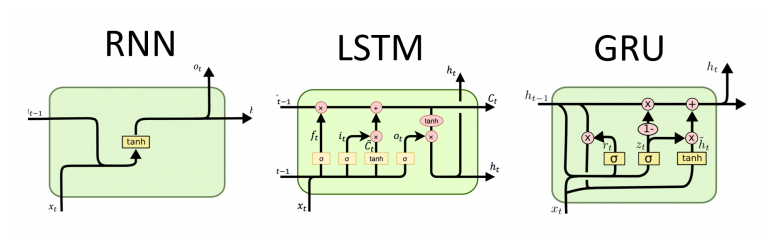

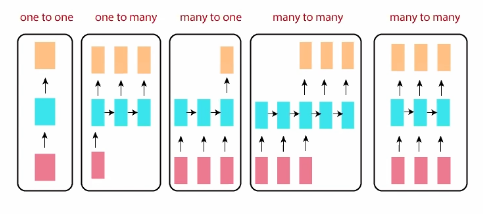
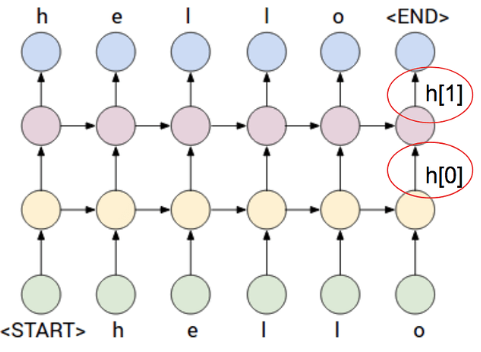

In [20]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

# Preprocess Text data
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

import pdb

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [43]:
# Device Configuration
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"device: {device}")

device: mps:0


In [22]:
!gdown https://drive.google.com/uc?id=11QEkMQN3nOhnVb1pl2O1NFdE9yEX3OmI

zsh:1: no matches found: https://drive.google.com/uc?id=11QEkMQN3nOhnVb1pl2O1NFdE9yEX3OmI


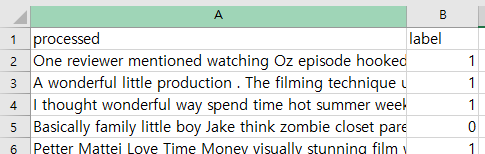

imdb_processed.csv

- 관사, 무의미한 단어는 전처리하여 지운 상태이다


processed -> 영화 리뷰 내용

label -> 긍정: 1 / 부정: 0

> 데이터 전처리 <br>
> 관사는 지운다 <br>
> clean 과정에서 html부호들을 제거한다 <br>
> 이모티콘을 제거해 준다 <br>
> 대명사나 전치사 같은 단어들은 긍정 부정 판단에 크게 도움이 되지 않은 단어들이기 때문에 제거


In [23]:
# read data
data = pd.read_csv('./imdb_processed.csv')
# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()
# check our list
words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [24]:
data

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1
...,...,...
49995,I thought movie right good job . It creative o...,1
49996,"Bad plot , bad dialogue , bad acting , idiotic...",0
49997,I Catholic taught parochial elementary school ...,0
49998,I going disagree previous comment side Maltin ...,0


In [25]:
# build vocabulary [단어 사전화]
counter = Counter(words) # 전체 단어들이 나온 횟수를 딕셔너리화
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [26]:
len(words)

7888384

문제점 : **7,888,384개의 단어**를 벡터화 해야 한다.
- 해결 방안 : 중복되는 단어를 제거해 주면 벡터화하는 단어가 줄어들게 된다

In [27]:
print(f"전체 단어 수: {len(words)}, 중복 단어 제거 후 --> {len(word2int)}")

전체 단어 수: 7888384, 중복 단어 제거 후 --> 121301


word2int 사전에는 각 단어별 빈도수가 기록되어 있다

In [28]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████████████████████████████| 50000/50000 [00:02<00:00, 23087.22it/s]


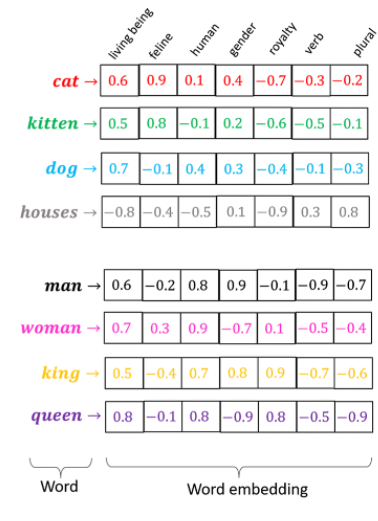

reviews의 문장을 숫자로 바꿔 나열한 것이다. 단어를 int화 하였다

- project때 하면 좋을 것 같다

In [29]:
# print first-10 words of 5 reviews
for i in range(6,10):
    print(reviews_enc[i][:10])

[3, 197, 18, 10, 21, 12517, 1904, 55922, 121, 5112]
[14, 31, 427, 2, 1342, 4021, 165, 34, 2960, 1]
[47893, 980, 359, 6, 3, 180, 776, 81, 6, 1]
[64, 10, 125, 2269, 5606, 1980, 10, 5, 1, 64]


In [30]:
print(f"{reviews[6]}\n\n{reviews[7]}\n\n{reviews[8]}\n\n{reviews[9]}")

I sure would like see resurrection dated Seahunt series tech today would bring back kid excitement . I grew black white TV Seahunt Gunsmoke hero every week . You vote comeback new sea hunt . We need change pace TV would work world water adventure . Oh way thank outlet like view many viewpoint TV many movie . So ole way I believe I got I wan na say . Would nice read plus point sea hunt . If rhyme would line would let submit , leave doubt quit , If I must go let .

This show amazing , fresh innovative idea first aired . The first year brilliant , thing dropped . By , show really funny anymore , continued decline complete waste time today . It truly disgraceful far show fallen . The writing painfully bad , performance almost bad - mildly entertaining respite guest - host , show probably still air . I find hard believe creator hand - selected original cast also chose band hack followed . How one recognize brilliance see fit replace mediocrity ? I felt I must give star respect original cast

In [31]:
# padding sequences [RNN input의 길이를 같게 맞춰주기 위해 짧은 문장을 zero padding, 긴 문장은 trim]
def pad_features(reviews, pad_id, seq_length = 256): 
    # 짧은 문장의 경우는 256단어까지 다 보고, 256단어보다 더 긴 문장은 그 뒤를 전부 자른다
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

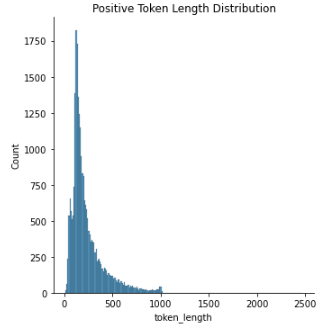 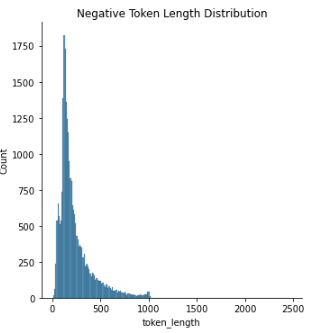

500단어보다 더 많은 리뷰는 비율이 적으므로, 과감히 버리기도 한다
- 이와 같이 데이터의 특성을 먼저 파악해야 좋은 성능을 내는 모델을 만들 수 있다

In [32]:
features[6]

array([    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
        5112,   416,    18,   637,    75,   152,  2256,     1,     3,
        1966,   303,   441,   153, 55922, 20486,   396,   103,   761,
           1,   111,  1620,  6674,   143,  1868,  3186,     1,   222,
         172,   379,   904,   153,    18,    63,   112,   898,   849,
           1,   509,    30,  2291, 11135,    10,   455,    51,  5515,
         153,    51,     5,     1,   158, 14928,    30,     3,   184,
           3,   102,     3,  2690,  1251,    48,     1,  3336,   253,
         245,  1164,    90,  1868,  3186,     1,    64,  7644,    18,
         116,    18,   211, 10123,     2,   488,   606,  4808,     2,
          64,     3,   124,    41,   211,     1,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

256단어로 길이를 맞추어 주면, 256단어보다 적은 리뷰는 위와 같이 중간부터 0으로 채워지게 된다.

In [33]:
# get labels as numpy
labels = data.label.to_numpy()

In [34]:
len(labels)

50000

### Split Dataset

In [44]:
# train test split
train_size = 0.7     # csv파일에 있는 Dataset 50,000개 중 35,000개를 train으로 사용
val_size = 0.5       # 나머지 15,000개 중 절반인 7,500개를 validation & 7,500개는 test set으로 사용

# make train set
split_id = int(len(features) * train_size) # len(features) = 50,000 / split_id = 35,000
# 주의 : 곱하기를 연산하면 data type이 float이 된다. 이러면 연산이 이상해지기 때문에, int로 바꿔준다
train_x, remain_x = features[:split_id], features[split_id:] # len(train_x) = 35,000 / len(remain_x) = 15,000
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size) # len(remain_x) = 15,000 / split_val_id = 7,500
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:] # len(val_x) = 7,500
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


지금까지 한 것과는 다르게, 직접 Train data와 Test set을 나누어 주어야 한다
- Train set : 256차원의 데이터가 35,000개 들어가 있다
- Test, Validation set : 256차원의 데이터가 7,500개 들어가 있다

#### Data Balancing
- 데이터의 균형을 맞춰주는 단계로, 매우 중요하다

In [45]:
# Check positive & negative data balance
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


Dataset이 unbalance한지 balance한지 미리 확인을 해 주어야 한다

### 3. Data Loader

In [46]:
# define batch size # RuntimeError: CUDA out of memory 에러 출력 시 batch_size 낮추고 실행
batch_size = 128

# create tensor datasets
train_set = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_set = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_set = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(valid_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

### 4. Model 구현

In [47]:
# Model Architecture
class Sentiment(nn.Module):
    def __init__(self, num_vocab, embedding_dim, hidden_dim, num_layers, out_node, drop_percent = 0.2):
        super(Sentiment, self).__init__()

        self.num_vocab = num_vocab
        # Input sentence to Vector Representation
        self.embed = nn.Embedding(num_embeddings=num_vocab, embedding_dim = embedding_dim) # Embedding 해준다. 즉, Vector화 하는것
        # 단어를 전부 256차원으로 만들어 준다
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size = hidden_dim, num_layers=num_layers, batch_first=True)
        #self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_percent)
        self.fc = nn.Linear(hidden_dim, out_node) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        x = x.long()
        x = self.embed(x)
        out, _ = self.lstm(x) # 실습 떄에는 h0과 c0을 적어주면 좋다
        #out, _ = self.gru(x), gru를 사용하고 싶다면 사용하면 된다
        out = self.dropout(out)
        out = self.fc(out[:,-1,:])
        out = self.sigmoid(out)
        return out

In [48]:
# Model Hyperparamters
vocab_size = len(word2int)
out_node = 1
embedding_dim = 256
hidden_dim = 512
num_layers = 2
dropout = 0.25
learning_rate = 0.001
num_epochs = 8

In [49]:
# model initialization
model = Sentiment(vocab_size, embedding_dim, hidden_dim, num_layers, out_node, dropout)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. Train & Evaluate

In [ ]:
# Train Loop
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []

best_valid_loss = torch.inf
best_epoch = 0
model = model.to(device)
epochloop = tqdm(range(num_epochs), position=0, desc='Training', leave=True)
for epoch in epochloop:
    model.train()
    train_loss = 0
    train_acc = 0

    ## Train
    for idx, (text, label) in enumerate(train_loader):
        epochloop.set_postfix_str(f'Training batch {idx}/{len(train_loader)}') # visualize
        text, label = text.to(device), label.to(device)

        out = model(text).squeeze(1)
        # acc
        train_acc += (torch.round(out).squeeze()==label.float()).sum()

        # loss
        optimizer.zero_grad()
        loss = criterion(out.squeeze(), label.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()   

    ## Validation
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(val_loader):
            epochloop.set_postfix_str(f'Validation batch {idx}/{len(val_loader)}')
            text, label = text.to(device), label.to(device)

            # forward pass
            out = model(text)
            # acc
            val_acc += (torch.round(out).squeeze()==label.float()).sum()

            # loss
            loss = criterion(out.squeeze(), label.float())
            val_loss += loss.item()
    model.train()
    # save model if validation loss decrease
    if val_loss / len(valid_set) <= best_valid_loss:
        best_valid_loss = val_loss / len(val_loader)
        best_epoch = epoch
        torch.save(model.state_dict(), "LSTM_epoch_{}.pth".format(epoch))

    # print epoch loss & accuracy
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_set) * 100}% | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(valid_set) * 100}%')
    tr_loss.append(train_loss / len(train_loader))
    tr_acc.append(train_acc.cpu().numpy() / len(train_set) * 100)
    v_loss.append(val_loss / len(val_loader))
    v_acc.append(val_acc.cpu().numpy() / len(valid_set) * 100)



Training:   0%|                     | 0/8 [00:00<?, ?it/s, Training batch 0/274]

3 epoch까지는 거의 차이가 없다가, 4 epoch부터는 학습이 좋아지는듯 하다

In [ ]:
plt.plot(range(num_epochs), tr_loss, label="Train Loss")
plt.plot(range(num_epochs), v_loss, label="Val Loss")
plt.legend()
plt.title("Loss - epoch")
plt.show()

In [ ]:
plt.plot(range(num_epochs), tr_acc, label="Train Acc")
plt.plot(range(num_epochs), v_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy - epoch")
plt.show()

### 6. Test

In [ ]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(test_loader, leave=True, desc='Inference')
with torch.no_grad():
    for text, label in testloop:
        text, label = text.to(device), label.to(device)

        # forward pass
        out = model(text)

        # acc
        test_acc += (torch.round(out).squeeze()==label.float()).sum()

        # loss
        loss = criterion(out.squeeze(), label.float())
        test_loss += loss.item()
    print("\n")
    print(f'Accuracy: {test_acc.cpu().numpy()/len(test_set) * 100}% / Loss: {test_loss/len(test_loader):.4f}')